# Monolayer WSe$_2$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import drawSvg as draw
from myst_nb import glue

def rot_mat(θ):
    return np.array([[np.cos(θ), -np.sin(θ)], [np.sin(θ), np.cos(θ)]])

We base our tight binding model of monolayer WSe$_2$ (mWSe$_2$) on the three band model (TBM) by Liu et al. {cite}`three_band`. In the TBM of mWSe2 the hopping is modeled using only the tungsten sites, forming a triangular lattice in the $xy$ plane with real space unit vectors:
```{math}
\vec a_1=\begin{pmatrix}1\\ 0\end{pmatrix}\text{ and } \vec a_2=\frac12\begin{pmatrix}1\\ \sqrt{3}\end{pmatrix},    
```
and reciprocal lattice vectors:
```{math}
\vec b_1=2\pi\begin{pmatrix}1\\ -1/\sqrt{3}\end{pmatrix}\text{ and } \vec b_2=2\pi\begin{pmatrix}0\\ 2/\sqrt{3}\end{pmatrix},    
```
where length is in units of the lattice spacing $a$ between two tungsten atoms.

We consider one atom as the origin and label every other atom using the integers $i$ and $j$ which connect this atom to their origin with the vector $i
\vec a_1 + j\vec a_2$:

In [2]:
class LatVec:
    # We identify each atom as the two integers i and j which connect it to the origin. 
    # Using a pythonic object we can define how two of these vectors interact.
    a_1 = np.array([1, 0])
    a_2 = np.array([1/2, np.sqrt(3)/2])
    b_1 = 2*np.pi * np.array([1, -1/np.sqrt(3)])
    b_2 = 2*np.pi * np.array([0, 2/np.sqrt(3)])
    
    def __init__(self, i, j, reciprocal=False, scale=1):
        self.i = i
        self.j = j
        self.scale = scale
        self.reciprocal = reciprocal
        self.vec = self.vectorize()
        
    def __add__(self, other):
        return LatVec(self.i+other.i, self.j+other.j)
    
    def __eq__(self, other):
        return (self.i==other.i) & (self.j==other.j)
    
    def __and__(self, other):
        # A simple way to get all hopping vectors from two unit vectors.
        return [self, other.neg(), self.neg()+other.neg(), self.neg(), other, self+other]
    
    def __mul__(self, other):
        if type(other) == LatVec:
            return np.dot(self.vec, other.vec)
        else:
            return np.dot(self.vec, other)
        
    def __rmul__(self, other):
        return self * other
    
    def neg(self):
        return LatVec(-self.i, -self.j)
    
    def vectorize(self):
        if self.reciprocal:
            return self.scale*(self.i*self.b_1 + self.j*self.b_2)
        else:
            return self.scale*(self.i*self.a_1 + self.j*self.a_2)
    
    def plot(self, container, atom_radius=0.2, atom_color='darkblue', θ=0, atom="", bonds=False, displace=0, **kwargs):
        origin = self.vec + displace
        a_list = [self.a_1, self.a_2, self.a_1-self.a_2]      
        if θ != 0:
            origin = rot_mat(θ) @ self.vec
            a_list = [rot_mat(θ) @ a for a in a_list]
        if bonds: 
            for a in a_list:
                container.append(draw.Line(*(origin-a/2), *(origin+a/2), **kwargs))
        gradient = draw.RadialGradient(*origin, atom_radius)
        gradient.addStop(0, 'white', 1)
        gradient.addStop(1, atom_color, 1)
        container.append(draw.Circle(*origin, atom_radius, fill=gradient, **kwargs))
        container.append(draw.Text(atom, atom_radius, *origin, text_anchor='middle', alignment_baseline="central"))
        return container
    
container = draw.Drawing(4, 2.3, origin='center', displayInline=False)
for (i, j) in [(i, j) for i in range(-3, 3) for j in range(-2, 2)]:
    container = LatVec(i, j).plot(container, stroke='black', atom_color='red', bonds=True, atom=str(i)+','+str(j), stroke_width=0.015)
    container = LatVec(i, j).plot(container, stroke='black', atom_color='blue', atom="Se2", stroke_width=0.01, 
                                  displace=[1/2, 1/3], atom_radius=0.15)
container.setRenderSize(1000)
glue('fig:lattice', container, display=False)

```{glue:figure} fig:lattice
```

The symmetric point group of this triangular lattice is $D_3$ with elements $\{E, C_3, C^2_3,\sigma_v, \sigma_v', \sigma_v''\}$. The rotations are in the $xy$ plane, while the reflections are with respect to the $yz$, $xz$ and $xy$ planes. $C_6$ is not a symmetry element of this lattice since this operation exchanges triangles containing Se$_2$ and empty triangles.

We restrict the orbitals of tungsten to the $d$ orbitals $d_{x^2-y^2}$, $d_{xy}$ and $d_{z^2}$, which dictate the low energy $K$ points. The other orbitals are either at a different energy scale or do not mix with these orbitals due to the symmetries of the lattice. Since $C_6$ is not a symmetry element, $C_2=C_6\prod C_3$ is not either.

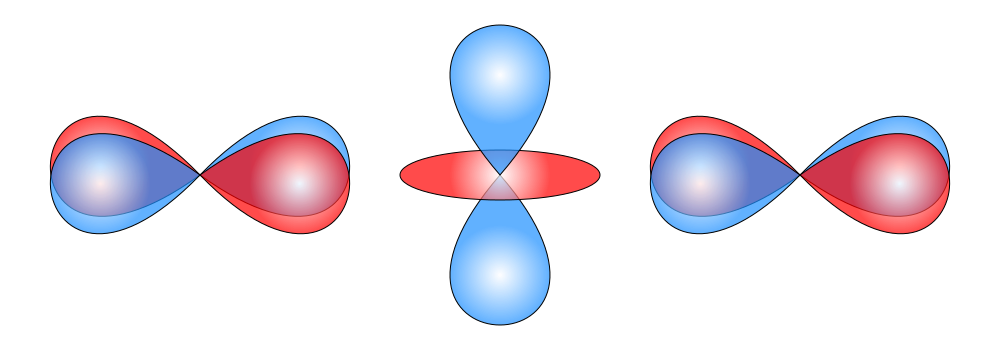

In [3]:
class Orbital:  
    
    def lobe(self, color, rotate=0, translate=(0, 0), stroke="black", **kwargs):
        gradient = draw.RadialGradient(0, 100, 50)
        gradient.addStop(0, 'white', 0.7)
        gradient.addStop(173.21, color, 0.7)
        transform = "translate(" + " ".join([str(i) for i in translate]) + ")\nrotate(" + str(rotate) + " 0 0)"
        return draw.Path(d="M 0,0 C -173.21,-200 173.21,-200 0,0 z", stroke=stroke, fill=gradient, transform=transform, **kwargs)
    
    def circle(self, color, ellipse=False, rotate=0, translate=(0, 0), stroke="black", **kwargs):
        gradient = draw.RadialGradient(0, 0, 50)
        gradient.addStop(0, 'white', 0.7)
        gradient.addStop(173.21, color, 0.7)
        transform = "rotate(" + str(rotate) + " 0 0)\ntranslate(" + " ".join([str(i) for i in translate]) + ")"
        if ellipse:
            clip = draw.ClipPath()
            clip.append(draw.Ellipse(0, 0, 50, 12.5, transform=transform))
            return draw.Ellipse(0, 0, 100, 25, stroke=stroke, fill=gradient, transform=transform, **kwargs) 
        else:
            return draw.Circle(0, 0, 50, stroke=stroke, fill=gradient, transform=transform, **kwargs)

class d_xy(Orbital):
    
    def __init__(self, container, translate=(0, 0), rotate=0):
        container.append(self.lobe("dodgerblue", rotate=85+rotate, translate=translate))
        container.append(self.lobe("red", rotate=95+rotate, translate=translate))
        container.append(self.lobe("red", rotate=275+rotate, translate=translate))
        container.append(self.lobe("dodgerblue", rotate=265+rotate, translate=translate))
        
class d_z2(Orbital):
    
    def __init__(self, container, translate=(0, 0), rotate=0):
        container.append(self.lobe("dodgerblue", rotate=180+rotate, translate=translate))
        container.append(self.circle("red", ellipse=True, rotate=rotate, translate=translate))
        container.append(self.lobe("dodgerblue", rotate=rotate, translate=translate))

container = draw.Drawing(1000, 350, origin="center")
d_z2(container)
d_xy(container, translate=(300, 0))
d_xy(container, translate=(-300, 0))
glue('fig:d_z2-d_xy', container, display=False)

```{glue:figure} fig:d_z2-d_xy
```

In [4]:
var_dic = {
    "t_1": 0.034, 
    "t_2": 0.263, 
    "t_3": -0.207, 
    "t_12": 0.329, 
    "t_13": 0.486, 
    "t_23": 0.457, 
    "ε_1": 2.179, 
    "ε_3": 0.942, 
    "λ_SOC": 0.228
}
t_1, t_2, t_3, t_12, t_13, t_23, ε_1, ε_3, λ_SOC = var_dic.values()
for var_key in var_dic:
    glue("var:"+var_key, var_dic[var_key], display=False)

0.034

0.263

-0.207

0.329

0.486

0.457

2.179

0.942

0.228

```{admonition} GGA coupling constants in eV
Coupling constants for WSe$_2$, subscripts 1, 2 and 3 refer to the $d_{x^2-y^2}$, $d_{xy}$ and $d_{z^2}$ orbitals respectively. These constants are for NN hopping left to right with respect to the $x$-axis. $\varepsilon_i$ are the on-site energies where $\varepsilon_1=\varepsilon_2$ due to symmetry. $\lambda_\text{SOC}$ is the spin orbit coupling. These are the GGA constants from {cite}`three_band`.
| $t_1$| $t_2$| $t_3$| $t_{12}$| $t_{13}$| $t_{23}$| $\varepsilon_1$| $\varepsilon_3$| $\lambda_{SOC}$|
|:----:|:----:|:----:|:-------:|:-------:|:-------:|:--------------:|:--------------:|:--------------:|
|{glue:}`var:t_1`|{glue:}`var:t_2`|{glue:}`var:t_3`|{glue:}`var:t_12`|{glue:}`var:t_13`|{glue:}`var:t_23`|{glue:}`var:ε_1`|{glue:}`var:ε_3`|{glue:}`var:λ_SOC`|
where all energies are measured in eV. 
```


 and collect them in the matrix $\mathcal E$:
```{math}
    \mathcal E = \begin{pmatrix}
        t_1&t_{12}&t_{13}\\
        -t_{12}&t_2&t_{23}\\
        t_{13}&-t_{23}&t_3
    \end{pmatrix}.
```

In [5]:
class Supercell:
    hop_list = LatVec(1, 0) & LatVec(0, -1)
    
    def __init__(self, m, n):
        self.v_1 = LatVec(m, n)    
        self.v_2 = LatVec(n+m, -m)
        self.w_1 = LatVec(m, n+m, True, 1/(m**2+m*n+n**2))
        self.w_2 = LatVec(n, -m, True, 1/(m**2+m*n+n**2))
        r = max(m, n)
        self.grid = [LatVec(i, j) for i in range(0, 3*r) for j in range(-r, r+1) if self.in_supercell(i, j)]
        self.N_atoms = len(self.grid)
        self.Δθ = np.arctan((n-m)/(n+m)/np.sqrt(3))
        self.construct_NN_array()
         
    def in_supercell(self, i, j, tol=10**-5):
        M = np.linalg.inv(np.array([self.v_1.vec, self.v_2.vec]).T)
        λ, μ = M @ LatVec(i, j).vec
        in_parellogram = (tol < λ < 1-tol) and (tol < μ < 1-tol) 
        return in_parellogram or (i, j) == (0, 0)
    
    def construct_NN_array(self):
        self.NN_array = np.zeros((self.N_atoms, 6, 2), dtype=int)
        for i in range(self.N_atoms):
            self.NN_array[i, :] = [self.find_NN(i, h_vec) for h_vec in self.hop_list]
            
    def find_NN(self, i, h_vec):
        for m, lat_vec in enumerate((self.v_1 & self.v_2) + [LatVec(0, 0)]):
            if self.grid[i]+h_vec+lat_vec in self.grid:
                return self.grid.index(self.grid[i]+h_vec+lat_vec), m
        raise Exception('No NN found for '+str(i)+' '+str(h_vec))
                
    def interlayer_hopping_array(self, supercell, tol=10**-5):
        if self.N_atoms != supercell.N_atoms:
            raise Exception('Supercells have a different number of atoms')
        if np.abs(self.Δθ + supercell.Δθ) > tol:
            raise Exception('Unequal twist angles')
        z_hopping = np.zeros((self.N_atoms, self.N_atoms, 2))
        for i in range(self.N_atoms):
            vec_i = supercell.grid[i].rot(-supercell.Δθ)    
            for j in range(self.N_atoms):
                min_ΔR = 10**6
                for lat_vec in (self.v_1 & self.v_2) + [LatVec(0, 0)]:
                    vec_j_trial = (self.grid[j]+lat_vec).rot(-self.Δθ)
                    if np.linalg.norm(vec_i-vec_j_trial) < min_ΔR:
                        min_ΔR = np.linalg.norm(vec_i-vec_j_trial)
                        vec_j = vec_j_trial
                z_hopping[i, j] = vec_i - vec_j
        return z_hopping
    
    def plot_supercell(self, grid_points=None, *, lat_vec=LatVec(0, 0), rotate=True, **kwargs):
        if grid_points == None:
            grid_points = range(self.N_atoms)
        grid_array = np.array([(self.grid[i]+lat_vec).rot(-self.Δθ*rotate) for i in grid_points])
        plt.scatter(grid_array[:, 0], grid_array[:, 1], **kwargs)

In [6]:
"""n, m = 6, 7
layer_1 = Supercell(n, m)
layer_2 = Supercell(m, n)
z_hopping = layer_1.interlayer_hopping_array(layer_2)
layer_1.Δθ*2*180/np.pi

j_1 = 2
j_2 = 44
for lat_vec in [layer_1.v_1+layer_1.v_2, layer_1.v_1,  layer_1.v_2, LatVec(0, 0)]:
    layer_1.plot_supercell(lat_vec=lat_vec, c='green', s=10)
    layer_1.plot_supercell(list(layer_1.NN_array[j_1, :]), lat_vec=lat_vec, c='blue', marker='d')
    layer_1.plot_supercell([j_1], lat_vec=lat_vec, c='blue', s=70, marker='D')
    layer_1.plot_supercell([j_2], lat_vec=lat_vec, c='blue', marker='D', s=70)
for lat_vec in [layer_2.v_1+layer_2.v_2, layer_2.v_1,  layer_2.v_2, LatVec(0, 0)]:
    layer_2.plot_supercell(lat_vec=lat_vec, c='orange', s=10)
    layer_2.plot_supercell([i for i in range(layer_2.N_atoms) if np.linalg.norm(z_hopping[i, j_2]) < 1], lat_vec=lat_vec, c='red', marker='d')

plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')"""

"n, m = 6, 7\nlayer_1 = Supercell(n, m)\nlayer_2 = Supercell(m, n)\nz_hopping = layer_1.interlayer_hopping_array(layer_2)\nlayer_1.Δθ*2*180/np.pi\n\nj_1 = 2\nj_2 = 44\nfor lat_vec in [layer_1.v_1+layer_1.v_2, layer_1.v_1,  layer_1.v_2, LatVec(0, 0)]:\n    layer_1.plot_supercell(lat_vec=lat_vec, c='green', s=10)\n    layer_1.plot_supercell(list(layer_1.NN_array[j_1, :]), lat_vec=lat_vec, c='blue', marker='d')\n    layer_1.plot_supercell([j_1], lat_vec=lat_vec, c='blue', s=70, marker='D')\n    layer_1.plot_supercell([j_2], lat_vec=lat_vec, c='blue', marker='D', s=70)\nfor lat_vec in [layer_2.v_1+layer_2.v_2, layer_2.v_1,  layer_2.v_2, LatVec(0, 0)]:\n    layer_2.plot_supercell(lat_vec=lat_vec, c='orange', s=10)\n    layer_2.plot_supercell([i for i in range(layer_2.N_atoms) if np.linalg.norm(z_hopping[i, j_2]) < 1], lat_vec=lat_vec, c='red', marker='d')\n\nplt.gca().set_aspect('equal', adjustable='box')\nplt.axis('off')"

Dit was de functie:

$$
f(x) = x^2
$$

```{bibliography} references.bib
```

In [7]:
[0, 0] + np.array([2, 0])

array([2, 0])

In [8]:
" ".join(["i", "r"])

'i r'

```{bibliography} references.bib
```